In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *

In [2]:
files = glob.glob(f'../data/nowcasts/KIT-baseline/*.csv') 

In [9]:
files[0][:-4].split('/')[-1].split('-', 5)[-1]

'KIT-baseline'

In [18]:
dfs = []
for file in files:
    df_temp = pd.read_csv(file, parse_dates=['forecast_date', 'target_end_date'])
    df_temp['model'] = file[:-4].split('/')[-1].split('-', 5)[-1]
    dfs.append(df_temp)
df = pd.concat(dfs)

In [19]:
target_sari = load_target_series('sari')

In [60]:
df = df[df.type == 'quantile']

In [61]:
df_plot = prepare_plot_data(df, target_sari)

In [62]:
def load_frozen_values(horizon):
    rt = load_rt(preprocessed=False)
    rt = rt.dropna()
    rt['value'] = rt.loc[:, 'value_0w' : f'value_{-1*horizon}w'].sum(axis=1)
    return rt[[c for c in rt.columns if 'value_' not in c]]

In [88]:
def plot_nowcasts(plot_data, stratum='national', horizon=0):
    df_frozen = load_frozen_values(horizon)

    if stratum == 'national':
        plotnine.options.figure_size = (6, 2.5)
        df_temp = plot_data[(plot_data.location == 'DE') & (plot_data.age_group == '00+')]
        frozen_temp = df_frozen[(df_frozen.location == 'DE') & (df_frozen.age_group == '00+')]
        facet = 'location'
        ncol = 1
        
    elif stratum == 'age':
        plotnine.options.figure_size = (12, 5)
        df_temp = plot_data[(plot_data.location == 'DE') & (plot_data.age_group != '00+')]
        frozen_temp = df_frozen[(df_frozen.location == 'DE') & (df_frozen.age_group != '00+')]
        facet = 'age_group'
        ncol = 3
    
    y_temp = df_temp[df_temp.type == 'truth']
    
    df_temp = df_temp[(df_temp.horizon == horizon) & (df_temp.type != 'truth')]
    y_temp = y_temp[y_temp.target_end_date.between(df_temp.target_end_date.min(), df_temp.target_end_date.max())]
    frozen_temp = frozen_temp[frozen_temp.date.between(df_temp.target_end_date.min(), df_temp.target_end_date.max())]
    # Get all Sundays within the range of the dataset
    sundays = get_sundays(df_temp['target_end_date'].min(), df_temp['target_end_date'].max())

    return (
        ggplot(df_temp, aes(x='target_end_date')) +
        facet_wrap(facet, ncol=ncol, scales='free_y') +
        geom_ribbon(aes(ymin='quantile_0.05', ymax='quantile_0.95'), 
                    fill='blue', alpha=0.3) +
        geom_line(aes(y='quantile_0.5'), color='blue') +
        geom_line(y_temp, aes(x='target_end_date', y='quantile_0.5'), color='black') +
        geom_line(frozen_temp, aes(x='date', y='value'), color='red') +
        # geom_point(y_temp, aes(x='target_end_date', y='quantile_0.5'), size=0.75) +
        scale_x_date(
            date_breaks='4 months',
            # breaks=[pd.Timestamp('2024-01-01'), pd.Timestamp('2024-03-01'), pd.Timestamp('2024-05-01')],
            # minor_breaks=sundays  # Add minor ticks at every Sunday
        ) +
        labs(x='Date', y='', title=f'{stratum.title()} — Horizon: {horizon}') +
        theme_bw() +
        theme(
            panel_grid_major_x=element_blank(),
            panel_grid_major_y=element_blank(),
            panel_grid_minor_y=element_blank(),
            panel_grid_minor=element_blank()
            #panel_grid_minor=element_line(color='grey', size=0.5)
        )
    )


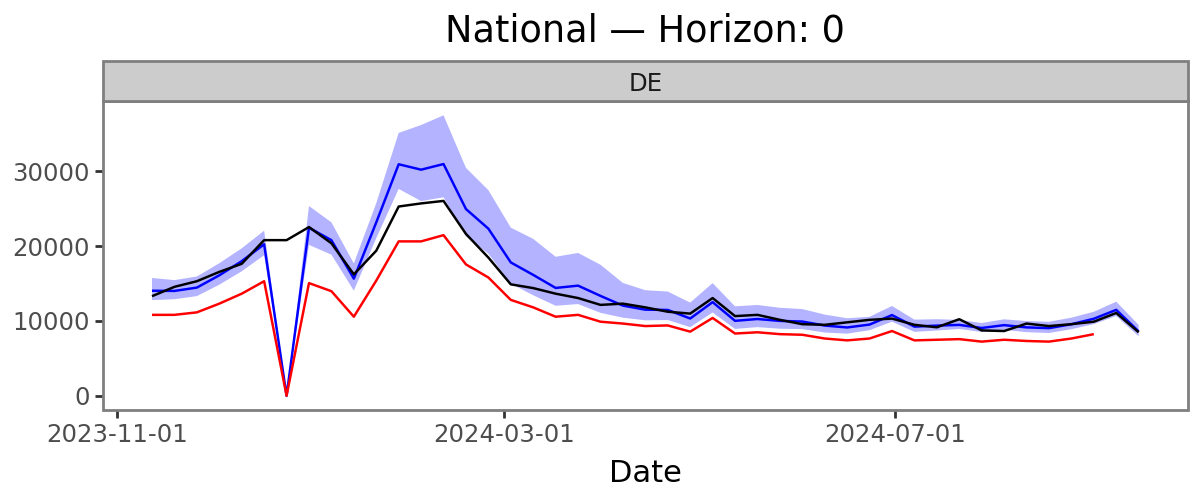

In [89]:
plot_nowcasts(df_plot)

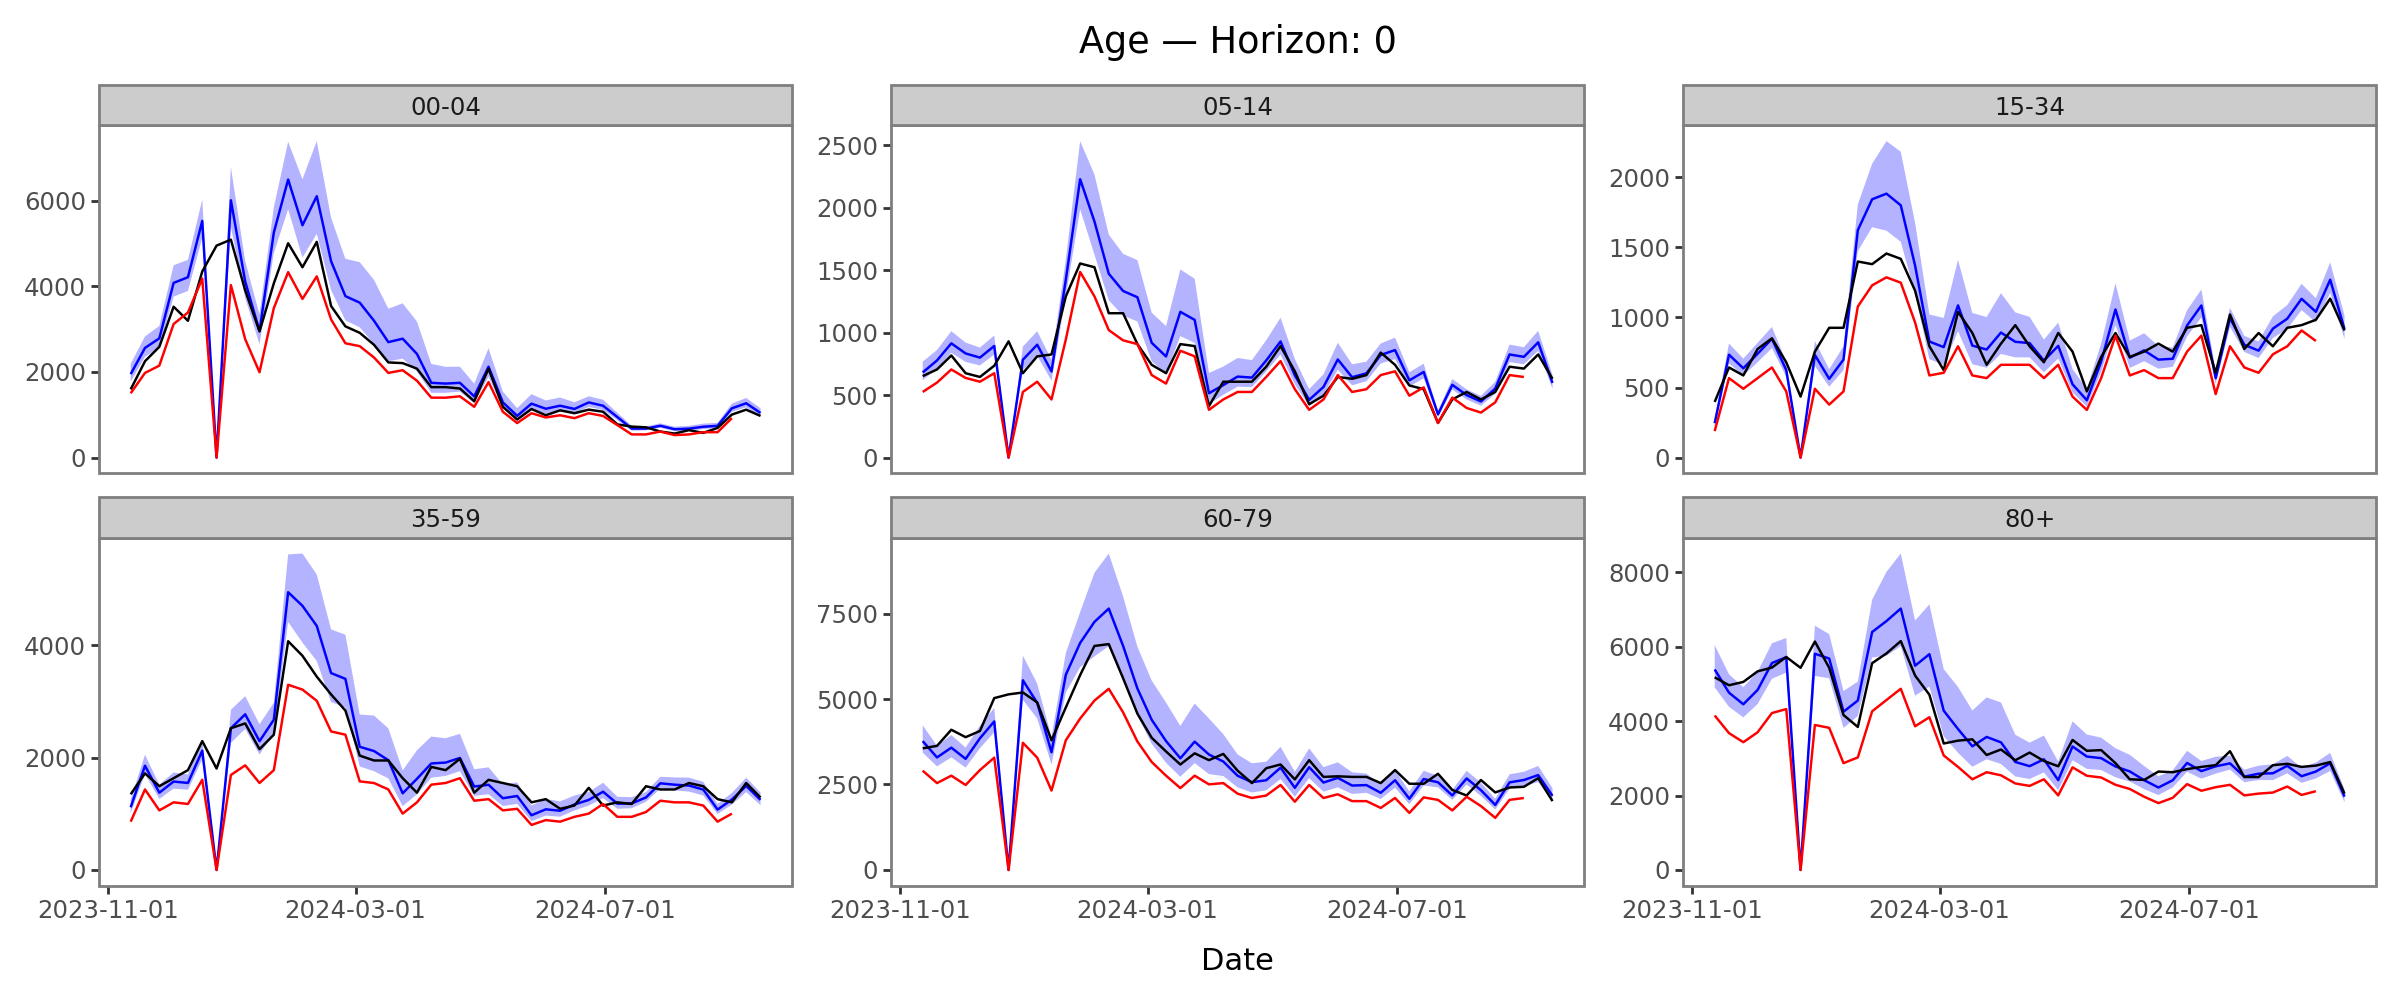

In [90]:
plot_nowcasts(df_plot, 'age')

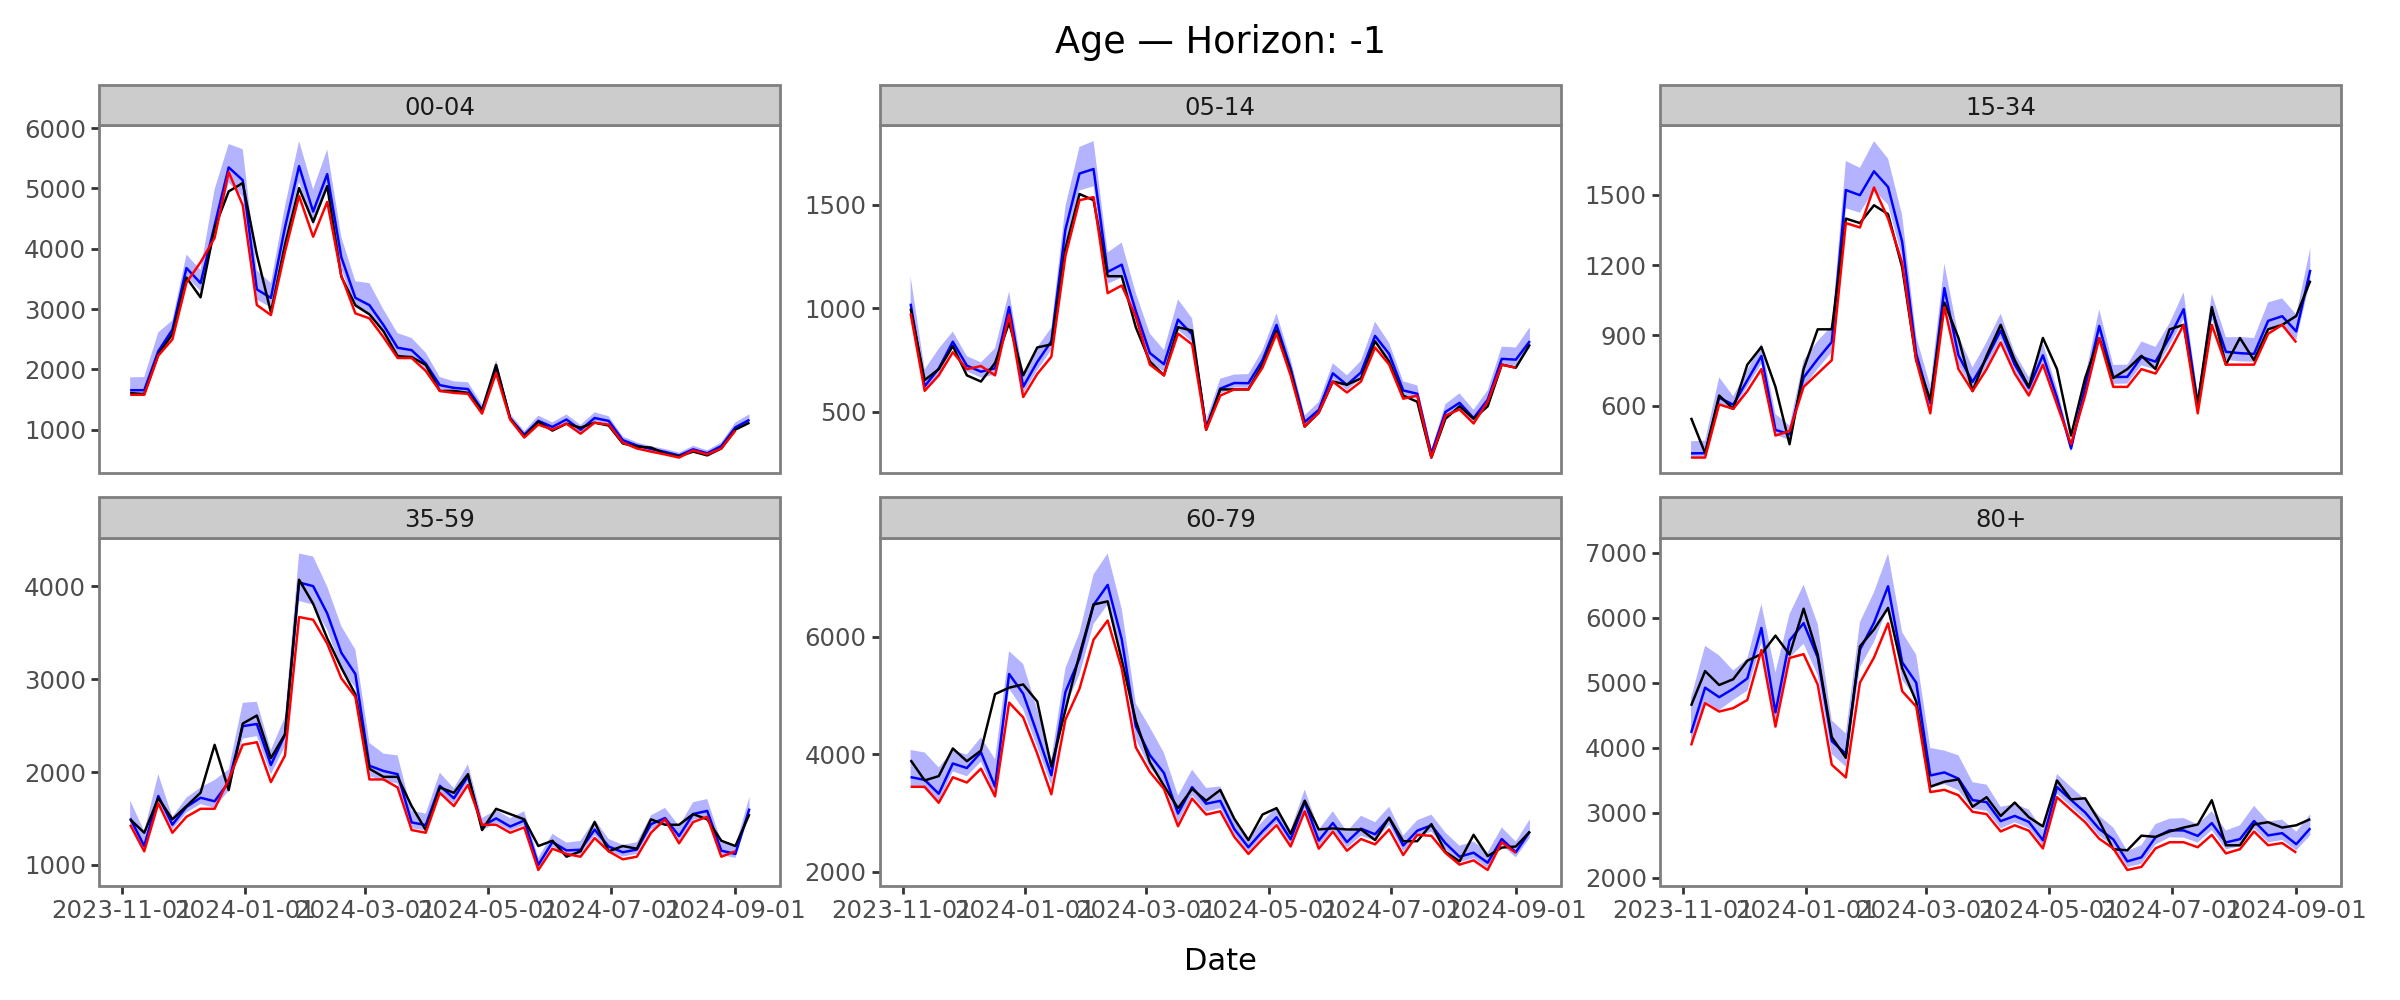

In [84]:
plot_nowcasts(df_plot, 'age', -1)

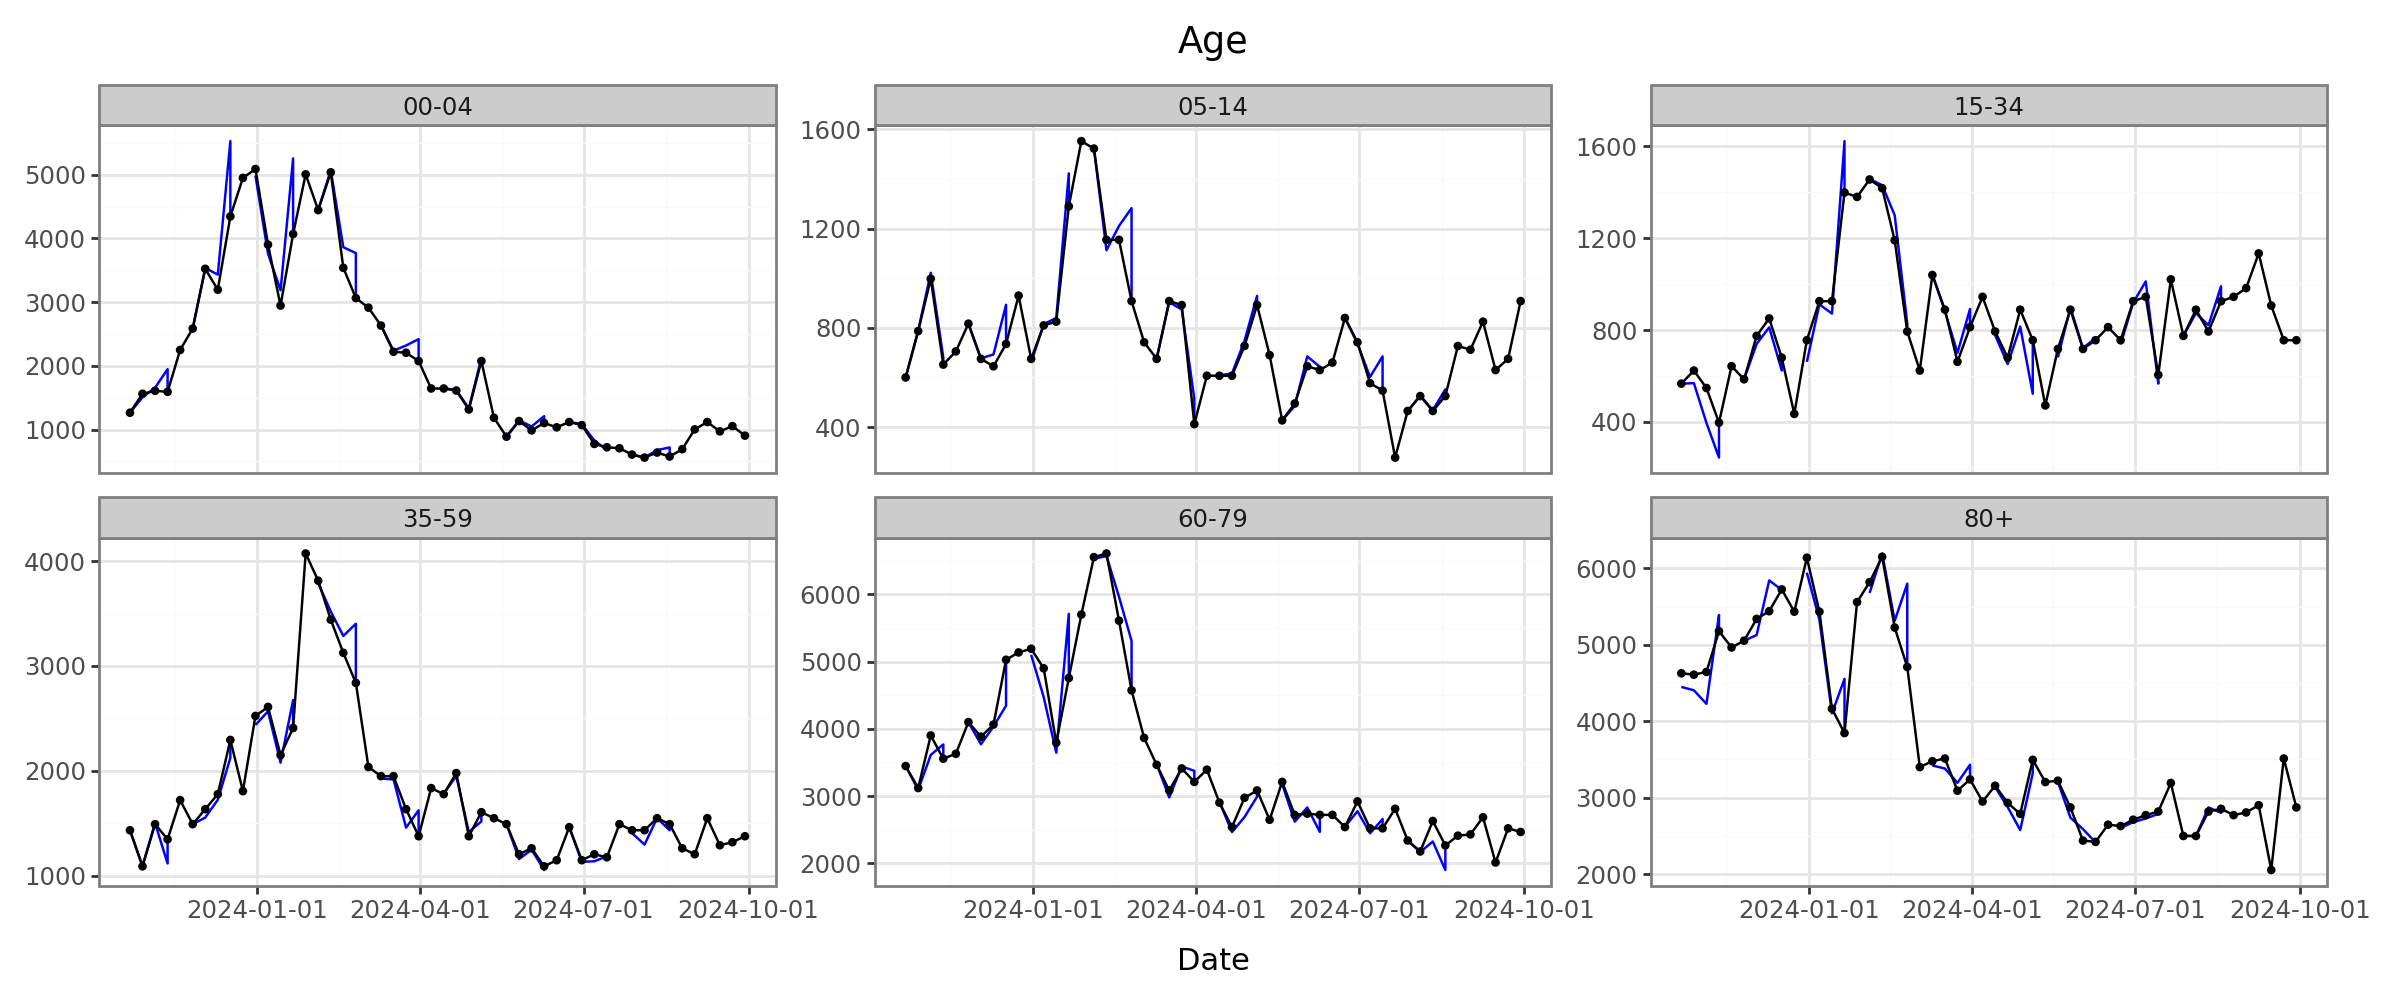

In [91]:
plot_forecasts(df_plot, 'age')